# Tohoku tsunami inversion part II:
### Inversion for an initial surface defined by a single radial basis function

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation

Misc plotting routines

In [4]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

Function for extracting timeseries data from file

In [7]:
def read_and_sample(g, sample=1):
    """Copied from `resources/gauges/plot_gauge_data.ipynb`"""
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t = []
    d = []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        running = 0
        for i in range(num_lines):
            line = f.readline()
            time, dat = line.split()
            time = float(time)
            dat = float(dat)
            running += dat
            if i % sample == 0 and i > 0:
                if time < time_prev:
                    break  # FIXME
                t.append(0.5*(time + time_prev))
                d.append(running/sample)
                running = 0
                time_prev = time
    return t, d

Define a mesh and a Taylor-Hood space upon it.

For quick results, let's just use the coarsest mesh of the hierarchy.

In [8]:
level = 0
# level = 1
# level = 2
op = TohokuOptions(level=level)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1
# plot_mesh(mesh);

Define fields for forward model, e.g. bathymetry from GEBCO.

In [9]:
b = Function(P1, name="Bathymetry").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

In [10]:
# plot_fields(eta_init, b, f);

Hand-coded Crank-Nicolson / Taylor-Hood solver for shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0
$$
equipped with boundary conditions
$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\partial\Omega}\equiv0\qquad
    \eta|_{\Gamma_{100}}\equiv0.
$$

In [11]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

This time we define the initial condition using radial basis functions.

For now, let's just use a one-dimensional basis.

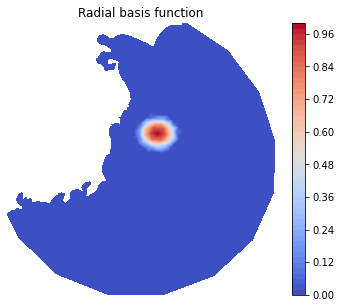

In [12]:
# This is the coefficient we will be tweaking
# m = Constant(1.0)
R = FunctionSpace(mesh, "R", 0)
m = Function(R).assign(1.0)

basis_function = Function(TaylorHood)
psi, phi = basis_function.split()
phi.interpolate(op.gaussian(mesh, custom_locs=[(0.7e+06, 4.2e+06, 96e+03), ]))
phi.dat.name = "Radial basis function"

plot_field(phi);

In [13]:
q_.project(m*basis_function)

Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fcc370a2be0>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fcc370a2be0>, FiniteElement('Lagrange', triangle, 1), name=None, index=1, component=None), name='None_None'), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 64)

Consider a time-dependent quantity of interest (QoI) which measures the goodness-of-fit at gauges

$$
J(\mathbf u,\eta)=\sum_{t\in\mathcal T}\sum_{g\in\mathcal G}\big|\:\eta(\mathbf x_g,t)-\eta_g(t)\:\big|,
$$

where $\mathcal T\subset(0, T]$ is a finite set of time levels and $\mathcal G\subset\Omega$ is a finite set of gauge coordinates.
For a given gauge $g$, $\eta_g(t)$ is the observed free surface height at time $t$ and $\mathbf x_g$ provides the UTM coordinates.

In order to evaluate such a QoI we first need to be able to represent the elevation at each gauge in $\mathcal H^1(\Omega)$.
Our approach is to use indicator functions of as narrow a radius as we can get away with.

In [14]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    x, y = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(op.ball(mesh, custom_locs=[(x, y, radius), ]), P0)

Next we need timeseries data at the gauges. (See notebook `resources/gauges/plot_gauge_data.ipynb`.)

__Notes__
  * We have done some averaging over samples in order to reduce noise.
  * The GPS gauges 801-806 contain `NaN`s.

In [15]:
for gauge in gauges:
    sample = 60 if gauge[0] == 'P' else 12
    op.gauges[gauge]['times'], op.gauges[gauge]['data'] = read_and_sample(gauge, sample=sample)
    
times = np.array(op.gauges['P02']['times'])
n = len(times)
for gauge in op.gps_gauges:
    op.gauges[gauge]['data'] = op.gauges[gauge]['data'][:-1]
for gauge in op.gauges:
    assert len(op.gauges[gauge]['data']) == n
    
for gauge in gauges:
    for i in range(n):
        if not np.isnan(op.gauges[gauge]['data'][i]):
            op.gauges[gauge]['data'] = np.array(op.gauges[gauge]['data']) - op.gauges[gauge]['data'][i]
            break

Now run the forward model, time integrating the QoI as time progresses.

In [16]:
t = 0.0
i = 0
J = 0
i_obs = 0
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
t_obs = Constant(op.end_time / len(times))
with stop_annotating():
    for gauge in gauges:
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx)
while t < op.end_time:
    solver.solve()
    
    # Time integrate QoI
    #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
    if np.allclose(t, times[i_obs]):
        print("observation {:2d} (t = {:.2f})".format(i_obs, t))
        weight = 1.0
        if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt:
            weight = 0.5
        u, eta = q.split()
        for gauge in op.gauges:
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
            eta_obs = op.gauges[gauge]['data'][i_obs]
            if not np.isnan(eta_obs):
                
                # Discrete form
                diff = abs(eta_discrete - eta_obs)
                op.gauges[gauge]['diff'].append(diff)
#                 J += weight*t_obs*diff

                # Continuous form
                diff = op.gauges[gauge]['indicator']*abs(eta - eta_obs)
                J_inc = assemble(weight*t_obs*diff*dx)
                J += J_inc
                with stop_annotating():
                    op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx)/op.gauges[gauge]['area'])
            else:
                op.gauges[gauge]['diff'].append(np.nan)
                op.gauges[gauge]['diff_smooth'].append(np.nan)
        i_obs += 1
        
        
    q_.assign(q)
    t += op.dt
    i += 1
    if i_obs == len(times):
        break
print("Quantity of interest = {:.4e}".format(J))

observation  0 (t = 30.00)
observation  1 (t = 90.00)
observation  2 (t = 150.00)
observation  3 (t = 210.00)
observation  4 (t = 270.00)
observation  5 (t = 330.00)
observation  6 (t = 390.00)
observation  7 (t = 450.00)
observation  8 (t = 510.00)
observation  9 (t = 570.00)
observation 10 (t = 630.00)
observation 11 (t = 690.00)
observation 12 (t = 750.00)
observation 13 (t = 810.00)
observation 14 (t = 870.00)
observation 15 (t = 930.00)
observation 16 (t = 990.00)
observation 17 (t = 1050.00)
observation 18 (t = 1110.00)
observation 19 (t = 1170.00)
observation 20 (t = 1230.00)
observation 21 (t = 1290.00)
observation 22 (t = 1350.00)
observation 23 (t = 1410.00)
Quantity of interest = 4.6868e+12


Compare initial and final solution

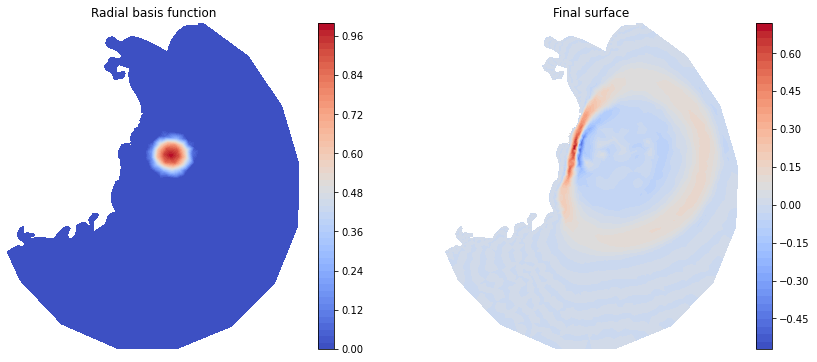

In [17]:
axes = plot_fields(phi, eta, height=6)

Form the reduced functional, passing in some callbacks to print progress of the optimisation routine

In [18]:
def derivative_cb_post(j, dj, m):
    print("functional value {:.8e}  derivatives {:.8e}  values {:.8e}".format(j, norm(dj), norm(m)))

Jhat = ReducedFunctional(J, Control(m), derivative_cb_post=derivative_cb_post)

Run the minimisation routine. We just use the dolfin-adjoint default, L-BFGS.

In [19]:
m_opt = minimize(Jhat, options={'ftol': 1.0e-04})

functional value 4.6868e+12  derivatives 3.6270e+17  values 9.8335e+05
functional value 4.3426e+12  derivatives 3.0060e+17  values 1.9667e+06
functional value 4.0402e+12  derivatives 1.7978e+17  values 6.7265e+06
functional value 3.8864e+12  derivatives 5.1333e+14  values 4.9451e+06
functional value 3.8864e+12  derivatives 5.1333e+14  values 4.9502e+06
functional value 3.8864e+12  derivatives 6.4853e+14  values 4.9705e+06
functional value 3.8864e+12  derivatives 3.7812e+14  values 4.9534e+06


In [20]:
print("Initial choice of basis coefficient: {:.8e}".format(*m.dat.data))
print("Optimised basis coefficient:         {:.8e}".format(*m_opt.dat.data))

Initial choice of basis coefficient: 1.00000000e+00
Optimised basis coefficient:         5.03731996e+00


Now that we've computed the optimised basis function, run the forward model again to see whether the timeseries match the data better.

In [21]:
with stop_annotating():
    u_.assign(0.0)
    eta_.project(m_opt*phi)
    t = 0.0
    i = 0
    J_opt = 0
    i_obs = 0
    for gauge in gauges:
        op.gauges[gauge]['diff_opt'] = []
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff_smooth_opt'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx)
    while t < op.end_time:
        solver.solve()

        # Time integrate QoI
        #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
        if np.allclose(t, times[i_obs]):
            print("observation {:2d} (t = {:.2f})".format(i_obs, t))
            weight = 1.0
            if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt:
                weight = 0.5
            u, eta = q.split()
            for gauge in op.gauges:
                eta_discrete = eta.at(op.gauges[gauge]["coords"])
                if op.gauges[gauge]['init'] is None:
                    op.gauges[gauge]['init'] = eta_discrete
                eta_discrete -= op.gauges[gauge]['init']
                op.gauges[gauge]['timeseries'].append(eta_discrete)
                eta_obs = op.gauges[gauge]['data'][i_obs]
                if not np.isnan(eta_obs):

                    # Discrete form
                    diff = abs(eta_discrete - eta_obs)
                    op.gauges[gauge]['diff_opt'].append(diff)

                    # Continuous form
                    diff = op.gauges[gauge]['indicator']*abs(eta - eta_obs)
                    J_inc = assemble(weight*t_obs*diff*dx)
                    J_opt += J_inc
                    op.gauges[gauge]['diff_smooth_opt'].append(assemble(diff*dx)/op.gauges[gauge]['area'])
                else:
                    op.gauges[gauge]['diff_opt'].append(np.nan)
                    op.gauges[gauge]['diff_smooth_opt'].append(np.nan)
            i_obs += 1


        q_.assign(q)
        t += op.dt
        i += 1
        if i_obs == len(times):
            break
    print("Quantity of interest = {:.4e}".format(J_opt))

observation  0 (t = 30.00)
observation  1 (t = 90.00)
observation  2 (t = 150.00)
observation  3 (t = 210.00)
observation  4 (t = 270.00)
observation  5 (t = 330.00)
observation  6 (t = 390.00)
observation  7 (t = 450.00)
observation  8 (t = 510.00)
observation  9 (t = 570.00)
observation 10 (t = 630.00)
observation 11 (t = 690.00)
observation 12 (t = 750.00)
observation 13 (t = 810.00)
observation 14 (t = 870.00)
observation 15 (t = 930.00)
observation 16 (t = 990.00)
observation 17 (t = 1050.00)
observation 18 (t = 1110.00)
observation 19 (t = 1170.00)
observation 20 (t = 1230.00)
observation 21 (t = 1290.00)
observation 22 (t = 1350.00)
observation 23 (t = 1410.00)
Quantity of interest = 3.8864e+12


In [25]:
print("Previous QoI value = {:.4e}".format(J))

Previous QoI value = 4.6868e+12


Observe that the QoI value has dropped by 17%.

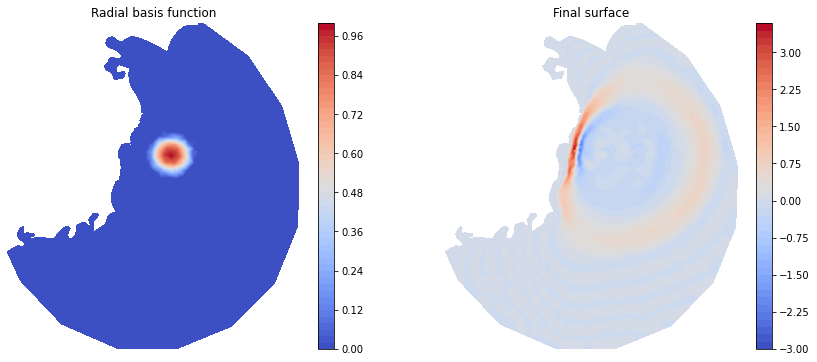

In [22]:
axes = plot_fields(phi, eta, height=6)

Let's see how well the timeseries approximate the data at each gauge. Note that since the QoI is formed of a summation, we shouldn't expect the accuracy of every timeseries to improve and indeed some will likely be worsened.

In [27]:
print("Continuous")
for gauge in gauges:
    tv = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_opt = total_variation(op.gauges[gauge]['diff_smooth_opt'])
    print("total variation for gauge {:s}: before {:.4e}  after {:.4e}".format(gauge, tv, tv_opt))
    
print("\nDiscrete")
for gauge in gauges:
    tv = total_variation(op.gauges[gauge]['diff'])
    tv_opt = total_variation(op.gauges[gauge]['diff_opt'])
    print("total variation for gauge {:s}: before {:.4e}  after {:.4e}".format(gauge, tv, tv_opt))

Discrete
total variation for gauge P02: before 1.3850e+01  after 1.3624e+01
total variation for gauge P06: before 1.0486e+01  after 1.1326e+01
total variation for gauge 801: before 2.4741e+00  after 1.2543e+00
total variation for gauge 802: before 3.5396e+00  after 3.3812e+00
total variation for gauge 803: before 3.0795e+00  after 1.4968e+00
total variation for gauge 804: before 2.0915e+00  after 2.5430e+00
total variation for gauge 806: before 1.4685e+00  after 1.3167e+00

Continuous
total variation for gauge P02: before 1.3689e+01  after 1.3945e+01
total variation for gauge P06: before 1.0517e+01  after 1.1045e+01
total variation for gauge 801: before 2.7101e+00  after 1.4733e+00
total variation for gauge 802: before 3.5809e+00  after 2.6431e+00
total variation for gauge 803: before 3.2331e+00  after 2.1320e+00
total variation for gauge 804: before 1.9972e+00  after 1.5262e+00
total variation for gauge 806: before 1.6143e+00  after 1.5026e+00
